In [100]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from e6dataflow.datamodel import load_datamodel, get_datamodel
from e6dataflow.tools.fittools import e6_fit
from scipy.optimize import curve_fit
import colorsys


In [101]:
### Load datamodel from .p file
run_name = 'run0'

datamodel = load_datamodel(datamodel_path=Path.cwd(), run_name=run_name)

Loading datamodel from Y:\expdata-e6\analysis\2021\03\02\run0\run0-datamodel.p


In [102]:
### Information about run:
### Note that molasses intensity is less than 5 for the first two frames,
### so better not use mol_freq = 4.5 and 5 for the 1/delta^2 fit!

tweezer_freq_list = [100,102,104,106,108,110,112,114,116,118,120]
num_tweezers = len(tweezer_freq_list)

probe_att_list = [0]
pzt_para_list = [5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]

num_points = datamodel.num_points #len(pzt_para_list) * len(probe_att_list)


mol_freq_list = [6.5,5,5.5,6,6.5,7,7.5]
num_frames = len(mol_freq_list) + 2

num_shots = datamodel.num_shots

num_loops = num_shots // num_points

print(num_points,'points')
print(num_frames,'frames')
print(num_tweezers,'tweezers')
print(num_shots,'shots')
print(num_loops,'complete loops')


t_exposure = 500

t_hold_1 = 100
t_hold_2 = 1000
t_hold_3 = 10000
t_frame_1 = t_exposure + t_hold_1
t_frame_2 = t_exposure + t_hold_2
t_frame_3 = t_exposure + t_hold_3

roi_width = 14
roi_height = 12
roi_area = roi_width * roi_width

10 points
9 frames
11 tweezers
4780 shots
478 complete loops


In [103]:
counts_array = np.zeros((num_frames,len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))

for point in range(num_points):
    probe_att_counter = point % len(probe_att_list)
    pzt_para_counter = point // len(probe_att_list)
    for frame_num in range(num_frames):
        for twz_counter in range(num_tweezers):
            counts_array[frame_num,probe_att_counter,pzt_para_counter,twz_counter,:]=\
                datamodel.get_data_by_point(f'frame-{frame_num:02d}_tweezer-{twz_counter:02d}_counts',point,\
                                           shots=range(num_loops*num_points))
            
print(counts_array.shape)

(9, 1, 10, 11, 478)


In [104]:
# Calculate cav_brightness and cav_fidelity for every shot!! 

cav_brightness = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_avg = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_sigma = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity_mov_avg = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity_mov_sigma = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))

num_avg = 12 # number of loops to put in moving average


ref_counts = counts_array[num_frames-1,:,:,:,:]
base = np.nanmean(ref_counts,3)

zeropeakHWFMper = 1.5
upper_threshold = base + 1.2 * zeropeakHWFMper * roi_area

base = np.repeat(base[:,:,:,np.newaxis],num_loops,axis=3)
upper_threshold = np.repeat(upper_threshold[:,:,:,np.newaxis], num_loops, axis=3)

counts_1 = counts_array[0,:,:,:,:]


for frame_num in range(num_frames - 2):
    mol_freq = mol_freq_list[frame_num]
    counts = counts_array[frame_num,:,:,:,:]
    counts_next = counts_array[frame_num+1,:,:,:,:]
    mask = counts_next > upper_threshold
    counts_post_selected = np.where(mask, counts, np.nan)

    atomcenter = np.nanmean(counts_post_selected,3)

    brightness = counts_post_selected - base ## should this be ref_counts (per shot) or base (averaged)
    brightness_sigma = np.nanstd(brightness,3)
    brightness_mean = np.nanmean(brightness,3)

    lower_threshold = atomcenter - 3 * brightness_sigma
    lower_threshold = np.repeat(lower_threshold[:,:,:,np.newaxis], num_loops, axis=3)

    # mask = counts_post_selected > lower_threshold ## getting warning about NaN. 

    mask = np.greater(counts_post_selected, lower_threshold, where=~np.isnan(counts_post_selected))
    counts_postpost_selected = np.where(mask, counts_post_selected, np.nan)
    
    atomcenter = np.nanmean(counts_postpost_selected,3)
    brightness = counts_postpost_selected - base ## should this be ref_counts (per shot) or base (averaged)
    brightness_mean = np.nanmean(brightness,3)
    brightness_sigma = np.nanstd(brightness,3)
    
    lower_threshold = atomcenter - 3 * brightness_sigma

    cav_brightness[frame_num,:,:,:,:] = brightness # num_frames x 
    cav_fidelity[frame_num,:,:,:,:] = np.where(counts>upper_threshold,1,0)

cav_brightness_mean = np.nanmean(cav_brightness,4)
cav_brightness_sigma = np.nanstd(cav_brightness,4)
cav_fidelity_mean = np.nanmean(cav_fidelity,4)
cav_fidelity_sigma = np.sqrt(num_loops*cav_fidelity_mean*(1-cav_fidelity_mean))/(num_loops)

for loop in range(num_loops):
    start_temp = np.maximum(np.ceil(loop-num_avg/2).astype(int),0)
    end_temp = np.minimum(np.floor(loop+num_avg/2).astype(int), num_loops)
    cav_brightness_mov_avg[:,:,:,:,loop] = np.nanmean(cav_brightness[:,:,:,:,start_temp:end_temp],4)
    cav_brightness_mov_sigma[:,:,:,:,loop] = np.nanstd(cav_brightness[:,:,:,:,start_temp:end_temp],4)
    cav_fidelity_mov_avg[:,:,:,:,loop] = np.nanmean(cav_fidelity[:,:,:,:,start_temp:end_temp],4)
    cav_fidelity_mov_sigma[:,:,:,:,loop] = np.nanstd(cav_fidelity[:,:,:,:,start_temp:end_temp],4)

c:\python37-32\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
c:\python37-32\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
c:\python37-32\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
c:\python37-32\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
c:\python37-32\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


[[34250.68341797221, 668.6750443393034], [9.98523889590308, 0.030223548447371927]]
[[33386.32864368507, 781.2192496632823], [9.946320309398107, 0.03564025605138592]]
[[33821.54368393986, 815.7745453613304], [9.886675196039823, 0.03580051430050464]]
[[34574.57308081227, 799.6095729976578], [9.852259760657073, 0.03399714949097254]]
[[34642.02979664364, 811.8386054563792], [9.850892690176591, 0.034503025308433806]]
[[34375.31971686835, 783.0441165352004], [9.809503716870662, 0.03329979855714949]]
[[33762.28954756144, 745.8041377762357], [9.789186959781276, 0.03168448727473108]]
[[33711.02825236751, 893.2086035202183], [9.807779607860388, 0.03871340923961823]]
[[31755.990275382806, 817.4851778643173], [9.790192807566479, 0.0368149545653568]]
[[30000.0, inf], [10.5, inf]]
[[30000.0, inf], [10.5, inf]]


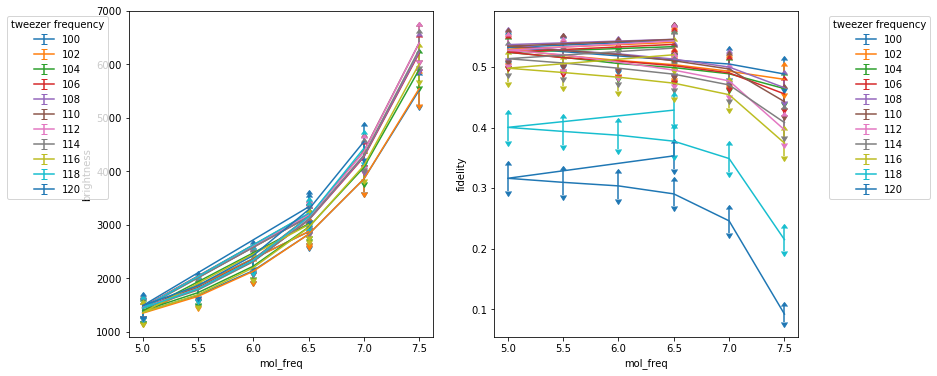

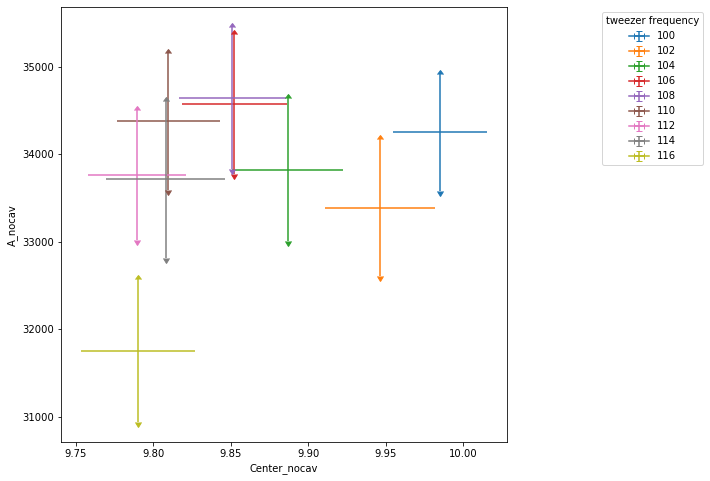

In [110]:

def func(x, a, center):
    return  a / (center-x)**2

fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
fig, ax2 = plt.subplots(1, 1,  figsize=(8, 8))
axs[0].set_xlabel('mol_freq')
axs[0].set_ylabel('brightness')
axs[1].set_xlabel('mol_freq')
axs[1].set_ylabel('fidelity')     
ax2.set_xlabel('Center_nocav')
ax2.set_ylabel('A_nocav')        
for tweezer_counter in range(len(tweezer_freq_list)):
    axs[0].errorbar(np.array(mol_freq_list), np.mean(cav_brightness_mean[:, 0, :, tweezer_counter],axis = 1), \
                yerr = np.mean(cav_brightness_sigma[:, 0, :, tweezer_counter],axis = 1),  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}')
    axs[1].errorbar(np.array(mol_freq_list), np.mean(cav_fidelity_mean[:, 0, :, tweezer_counter],axis = 1), \
                yerr = np.mean(cav_fidelity_sigma[:, 0, :, tweezer_counter],axis = 1),  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}')
    popt, pcov = curve_fit(func, np.array(mol_freq_list)[0:], np.nanmean(cav_brightness_mean[0:, 0, :, tweezer_counter],axis = 1),\
                               sigma = np.mean(cav_brightness_sigma[0:, 0, :, tweezer_counter],axis = 1),\
                           p0=[30000, 10.5], maxfev = 10000)
    a_nocav, center_nocav = popt
    sigma_a_nocav, sigma_center_nocav = np.sqrt(pcov.diagonal())
    print([[a_nocav,sigma_a_nocav],[center_nocav,sigma_center_nocav]])
    if tweezer_counter < 9:
        ax2.errorbar(center_nocav, a_nocav, \
           xerr = sigma_center_nocav, yerr = sigma_a_nocav,  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}')
    
axs[0].legend(title='tweezer frequency', bbox_to_anchor=(-0.05, 1), loc='upper right')
axs[1].legend(title='tweezer frequency', bbox_to_anchor=(1.45, 1), loc='upper right')
ax2.legend(title='tweezer frequency', bbox_to_anchor=(1.45, 1), loc='upper right')

Now we're starting to see something!! ^^

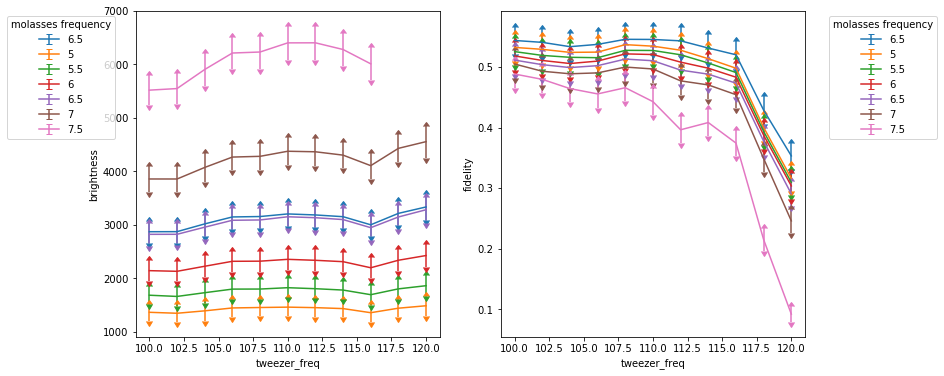

In [106]:

fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
axs[0].set_xlabel('tweezer_freq')
axs[0].set_ylabel('brightness')
axs[1].set_xlabel('tweezer_freq')
axs[1].set_ylabel('fidelity')        
for mol_counter in range(len(mol_freq_list)):
    axs[0].errorbar(np.array(tweezer_freq_list), np.mean(cav_brightness_mean[mol_counter, 0, :, :],axis = 0), \
                yerr = np.mean(cav_brightness_sigma[mol_counter, 0, :, :],axis = 0),  uplims=True, lolims=True, label= f'{mol_freq_list[mol_counter]}')
    axs[1].errorbar(np.array(tweezer_freq_list), np.mean(cav_fidelity_mean[mol_counter, 0, :, :],axis = 0), \
                yerr = np.mean(cav_fidelity_sigma[mol_counter, 0, :, :],axis = 0),  uplims=True, lolims=True, label= f'{mol_freq_list[mol_counter]}')
    
axs[0].legend(title='molasses frequency', bbox_to_anchor=(-0.05, 1), loc='upper right')
axs[1].legend(title='molasses frequency', bbox_to_anchor=(1.45, 1), loc='upper right')

AC Stark shift found in above fits using brightness vs mol_freq data. Do this for every loop???? 

tweezer=100, center_nocav = 0.9986, a_nocav = 3.4279
tweezer=102, center_nocav = 0.9947, a_nocav = 3.3410
tweezer=104, center_nocav = 0.9887, a_nocav = 3.3829
tweezer=106, center_nocav = 0.9853, a_nocav = 3.4585
tweezer=108, center_nocav = 0.9851, a_nocav = 3.4647
tweezer=110, center_nocav = 0.9810, a_nocav = 3.4392
tweezer=112, center_nocav = 0.9790, a_nocav = 3.3778
tweezer=114, center_nocav = 0.9807, a_nocav = 3.3697
tweezer=116, center_nocav = 0.9791, a_nocav = 3.1772
tweezer=118, center_nocav = 0.9705, a_nocav = 3.2322
[0.999  1.     0.9107 0.8348 0.8801 0.885  0.8758 0.8771 0.8758 0.8695
 0.0102]


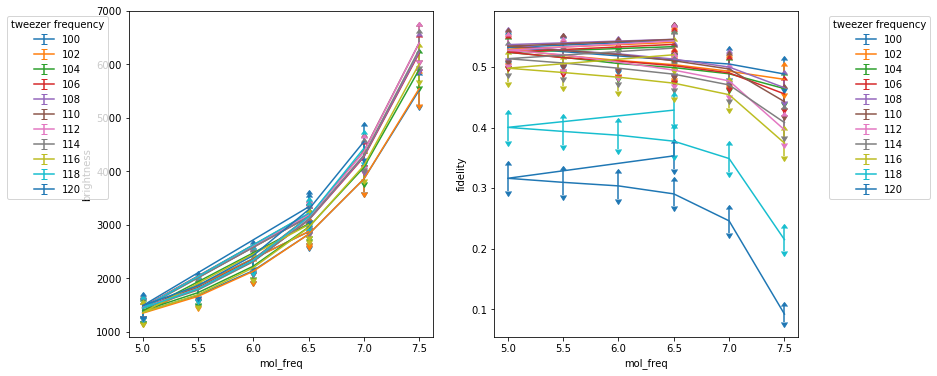

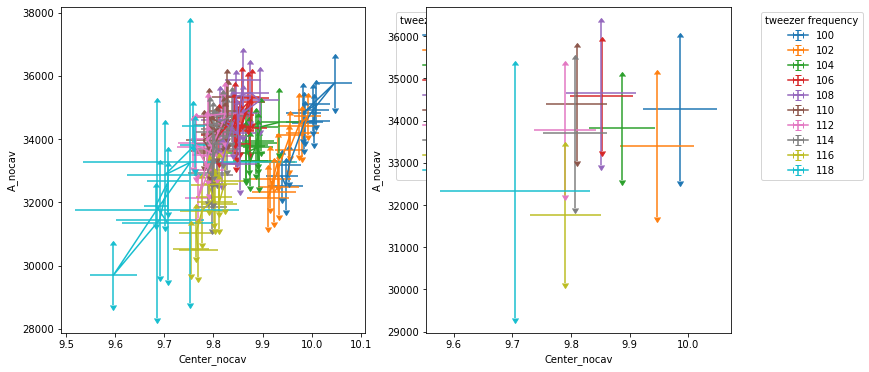

In [139]:

def func(x, a, center):
    return  a / (center-x)**2

fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
fig, ax2 = plt.subplots(1, 2,  figsize=(12, 6))
axs[0].set_xlabel('mol_freq')
axs[0].set_ylabel('brightness')
axs[1].set_xlabel('mol_freq')
axs[1].set_ylabel('fidelity')     
ax2[0].set_xlabel('Center_nocav')
ax2[0].set_ylabel('A_nocav')        
ax2[1].set_xlabel('Center_nocav')
ax2[1].set_ylabel('A_nocav')  
stark = np.zeros(len(tweezer_freq_list))
mol_int = np.zeros(len(tweezer_freq_list))
for tweezer_counter in range(len(tweezer_freq_list)):
    axs[0].errorbar(np.array(mol_freq_list), np.mean(cav_brightness_mean[:, 0, :, tweezer_counter],axis = 1), \
                yerr = np.mean(cav_brightness_sigma[:, 0, :, tweezer_counter],axis = 1),  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}')
    axs[1].errorbar(np.array(mol_freq_list), np.mean(cav_fidelity_mean[:, 0, :, tweezer_counter],axis = 1), \
                yerr = np.mean(cav_fidelity_sigma[:, 0, :, tweezer_counter],axis = 1),  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}')
    center_nocav_list=[]
    a_nocav_list=[]
    sigma_center_nocav_list=[]
    sigma_a_nocav_list=[]
    for pzt_counter in range(len(pzt_para_list)):
        valid = ~(np.isnan(cav_brightness_mean[:, 0, pzt_counter, tweezer_counter]) |\
                      np.isnan(cav_brightness_sigma[:, 0, pzt_counter, tweezer_counter]))
        popt, pcov = curve_fit(func, np.array(mol_freq_list)[valid], cav_brightness_mean[valid, 0, pzt_counter, tweezer_counter],\
                                   sigma = cav_brightness_sigma[valid, 0, pzt_counter, tweezer_counter],\
                               p0=[30000, 10.5], maxfev = 10000)
        a_nocav, center_nocav = popt
        sigma_a_nocav, sigma_center_nocav = np.sqrt(pcov.diagonal())
#         print([[a_nocav,sigma_a_nocav],[center_nocav,sigma_center_nocav]])
        center_nocav_list.append(center_nocav)
        a_nocav_list.append(a_nocav)
        sigma_center_nocav_list.append(sigma_center_nocav)
        sigma_a_nocav_list.append(sigma_a_nocav)
    stark[tweezer_counter] = np.mean(center_nocav_list)/10
    mol_int[tweezer_counter] = np.mean(a_nocav_list)/10000
    if tweezer_counter < 10:
        ax2[0].errorbar(center_nocav_list, a_nocav_list, \
           xerr = sigma_center_nocav_list, yerr = sigma_a_nocav_list,  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}')
    
        ax2[1].errorbar(np.mean(center_nocav_list), np.mean(a_nocav_list), \
           xerr = np.mean(sigma_center_nocav_list)+np.std(center_nocav_list), yerr = np.mean(sigma_a_nocav_list)+np.std(a_nocav_list),  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}')
        print(f'tweezer={tweezer_freq_list[tweezer_counter]}, center_nocav = {np.mean(center_nocav_list)/10:.4f}, a_nocav = {np.mean(a_nocav_list)/10000:.4f}')
axs[0].legend(title='tweezer frequency', bbox_to_anchor=(-0.05, 1), loc='upper right')
axs[1].legend(title='tweezer frequency', bbox_to_anchor=(1.45, 1), loc='upper right')
ax2[0].legend(title='tweezer frequency', bbox_to_anchor=(1.45, 1), loc='upper right')
ax2[1].legend(title='tweezer frequency', bbox_to_anchor=(1.45, 1), loc='upper right')
stark = stark / np.amax(stark[:-1])
mol_int = mol_int / np.amax(mol_int)

order = 0.5
mag_A_pre = np.array([1,0.999,0.907,0.830,0.875,0.878,0.868,0.870,0.868,0.858,0.880])
mag_A_post = mag_A_pre / stark**order
mag_A_post = mag_A_post / np.amax(mag_A_post[:-1])
np.set_printoptions(precision=4,suppress=True)
print(mag_A_post)